In [1]:
# Install required libraries
!pip install onnx onnxruntime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.0 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import onnxruntime as ort
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from google.colab import files
from PIL import Image


In [3]:
# Upload the model
uploaded_files = files.upload()  # Upload the .onnx model file

Saving resnet101_model.onnx to resnet101_model.onnx


In [4]:
onnx_path = next(iter(uploaded_files.keys()))
print(f"Model {onnx_path} uploaded successfully.")

Model resnet101_model.onnx uploaded successfully.


In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 224

In [6]:
# Test dataset transformations
transform_test = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Test dataset directory
test_dir = '/content/drive/MyDrive/update dataset/New Chest(5 class)/Test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Class names
class_names = test_dataset.classes
print(f"Classes: {class_names}")


Classes: ['Covid-19', 'Emphysema', 'Healthy', 'Pneumonia', 'Tuberculosis', 'random']


In [9]:
# Load ONNX model
ort_session = ort.InferenceSession(onnx_path)

In [10]:
# Prediction function for ONNX
def predict_onnx(ort_session, image):
    input_tensor = image.astype(np.float32)
    outputs = ort_session.run(None, {"input": input_tensor})
    return outputs[0]


In [11]:
# Evaluate the model on the test set
total_loss = 0.0
correct = 0
total_samples = 0
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)
criterion = torch.nn.CrossEntropyLoss()

all_preds = []
all_labels = []


In [12]:
for images, labels in test_loader:
    images_np = images.numpy()
    batch_loss = 0.0

    for i, img in enumerate(images_np):
        img_np = np.expand_dims(img, axis=0)  # Expand dimensions for ONNX input
        preds = predict_onnx(ort_session, img_np)
        predicted_label = np.argmax(preds)

        # Track loss
        loss = criterion(torch.tensor(preds), torch.tensor([labels[i]]))
        batch_loss += loss.item()

        # Update class-wise metrics
        class_correct[labels[i]] += (predicted_label == labels[i])
        class_total[labels[i]] += 1

        # Track overall metrics
        correct += (predicted_label == labels[i])
        total_samples += 1

        all_preds.append(predicted_label)
        all_labels.append(labels[i])

    total_loss += batch_loss

# Calculate overall metrics
total_accuracy = 100 * correct / total_samples
average_loss = total_loss / total_samples

# Print results
print(f"Total Accuracy: {total_accuracy:.2f}%")
print(f"Total Loss: {average_loss:.4f}\n")


Total Accuracy: 96.92%
Total Loss: 0.1005



In [13]:
# Class-wise metrics
for i, class_name in enumerate(class_names):
    class_accuracy = 100 * class_correct[i] / class_total[i]
    print(f"{class_name}: Accuracy: {class_accuracy:.2f}%, Loss: {class_correct[i]:.4f}")

Covid-19: Accuracy: 95.00%, Loss: 190.0000
Emphysema: Accuracy: 97.50%, Loss: 195.0000
Healthy: Accuracy: 97.00%, Loss: 194.0000
Pneumonia: Accuracy: 97.50%, Loss: 195.0000
Tuberculosis: Accuracy: 94.50%, Loss: 189.0000
random: Accuracy: 100.00%, Loss: 200.0000


In [14]:
# Upload and predict single image
uploaded_image = files.upload()
image_path = next(iter(uploaded_image.keys()))
image = Image.open(image_path).convert("RGB")
image_tensor = transform_test(image).unsqueeze(0).numpy()

Saving person543_bacteria_2284.jpeg to person543_bacteria_2284.jpeg


In [15]:
# Predict using ONNX model
output = predict_onnx(ort_session, image_tensor)
predicted_class = np.argmax(output)


In [16]:
print("\nSingle Image Prediction:")
print(f"Predicted Class: {class_names[predicted_class]}")


Single Image Prediction:
Predicted Class: Pneumonia


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
# Convert class_correct and class_total to NumPy arrays
class_correct = np.array(class_correct)
class_total = np.array(class_total)


In [23]:
# Prepare class-wise metrics
class_metrics = {
    "Class": class_names,
    "Accuracy (%)": [100 * class_correct[i] / class_total[i] for i in range(len(class_names))],
    "Samples": class_total.tolist()
}

In [24]:
# Convert to DataFrame
df_metrics = pd.DataFrame(class_metrics)

# Print metrics as a table
print(df_metrics)

# Visualize class-wise metrics
plt.figure(figsize=(12, 6))


          Class  Accuracy (%)  Samples
0      Covid-19          95.0      200
1     Emphysema          97.5      200
2       Healthy          97.0      200
3     Pneumonia          97.5      200
4  Tuberculosis          94.5      200
5        random         100.0      200


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

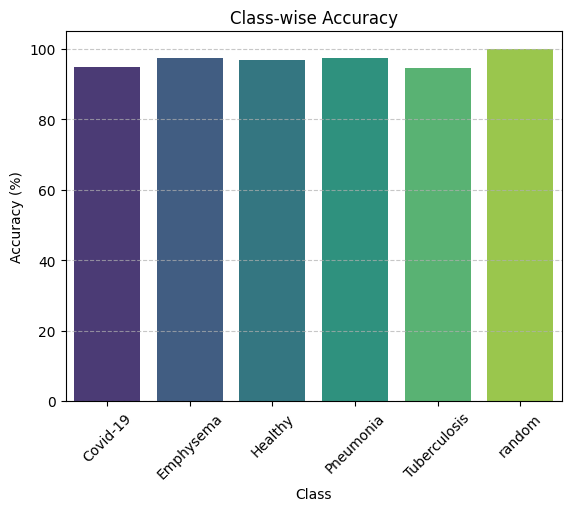

In [25]:
# Plot Accuracy
sns.barplot(x="Class", y="Accuracy (%)", data=df_metrics, hue="Class", dodge=False, palette="viridis")
plt.title("Class-wise Accuracy")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend([], [], frameon=False)  # Remove legend
plt.show()


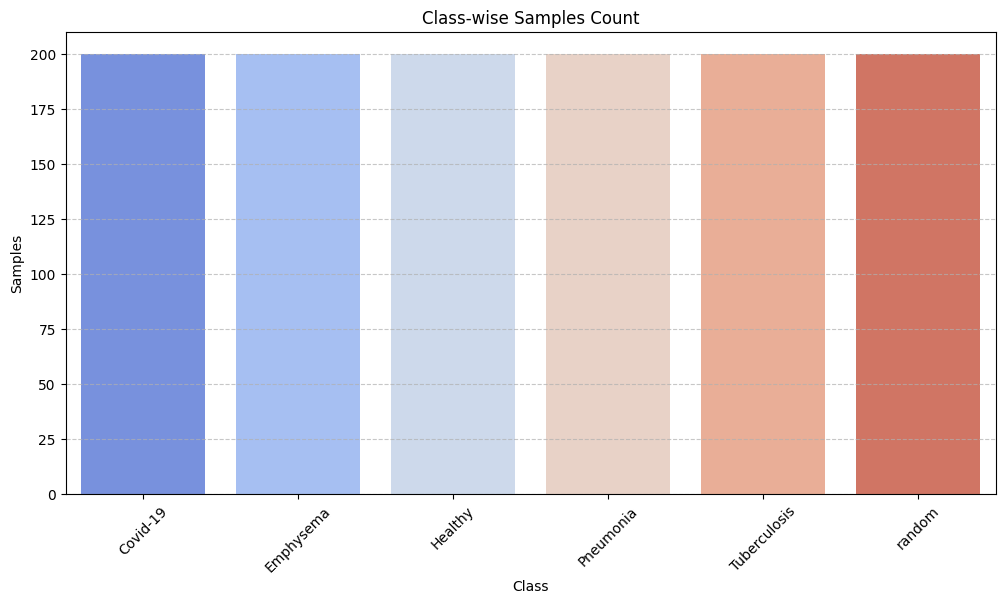

In [26]:
# Plot Samples Count
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Samples", data=df_metrics, hue="Class", dodge=False, palette="coolwarm")
plt.title("Class-wise Samples Count")
plt.ylabel("Samples")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend([], [], frameon=False)  # Remove legend
plt.show()

**Confusion Matrix**

<Figure size 1000x800 with 0 Axes>

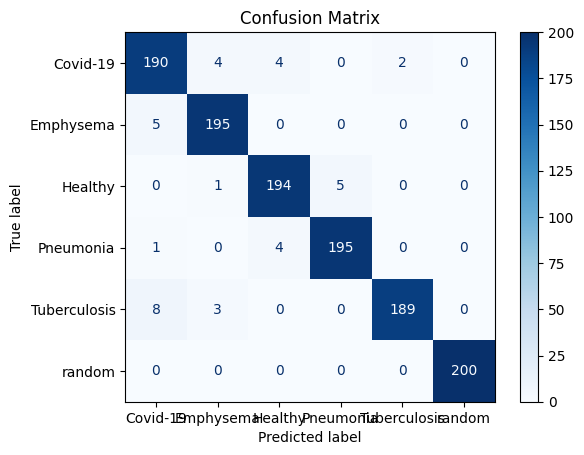

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format=".0f")
plt.title("Confusion Matrix")
plt.show()


** Precision, Recall, and F1-Score for Each Class**

In [28]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

    Covid-19       0.93      0.95      0.94       200
   Emphysema       0.96      0.97      0.97       200
     Healthy       0.96      0.97      0.97       200
   Pneumonia       0.97      0.97      0.97       200
Tuberculosis       0.99      0.94      0.97       200
      random       1.00      1.00      1.00       200

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



**ROC Curve and AUC**

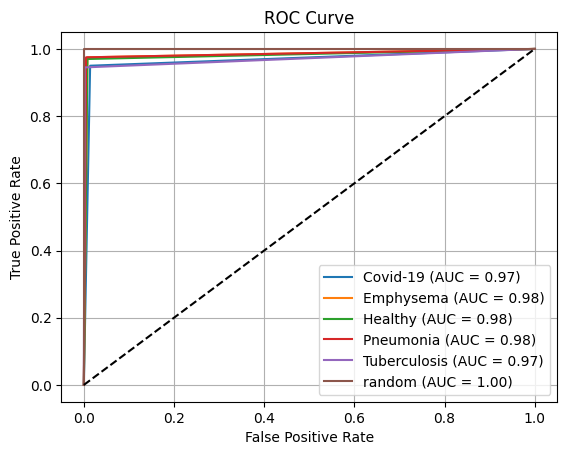

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC curve
n_classes = len(class_names)
labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))
preds_bin = label_binarize(all_preds, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], preds_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


**Grad-CAM (Class Activation Maps)**

In [36]:
!pip install pytorch-grad-cam --quiet


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [35]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

print("pytorch-grad-cam installed and imported successfully.")


ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [34]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Initialize Grad-CAM
target_layers = [model.layer4[-1]]  # Last convolutional layer
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# Run Grad-CAM for a single image
image_tensor = images[0].unsqueeze(0).to(device)  # Example: first image in the batch
target_category = preds[0]  # Predicted class for the first image
grayscale_cam = cam(input_tensor=image_tensor, target_category=target_category)

# Visualize Grad-CAM overlay
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(images[0].permute(1, 2, 0).cpu().numpy(), grayscale_cam)
plt.imshow(visualization)
plt.title(f"Grad-CAM for Class: {class_names[target_category]}")
plt.show()


ModuleNotFoundError: No module named 'pytorch_grad_cam'

**Misclassification Analysis**

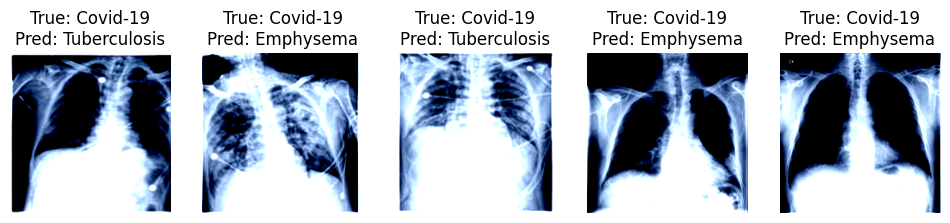

In [31]:
# Find misclassified samples
misclassified_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if pred != label]

# Display a few misclassified images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(misclassified_indices[:5]):  # Display first 5 misclassified images
    plt.subplot(1, 5, i + 1)
    img = test_dataset[idx][0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"True: {class_names[all_labels[idx]]}\nPred: {class_names[all_preds[idx]]}")
    plt.axis("off")
plt.show()


**Matthews Correlation Coefficient (MCC)**

In [37]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.9630


**Cohen's Kappa**

In [38]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa: {kappa:.4f}")


Cohen's Kappa: 0.9630


**Balanced Accuracy**

In [39]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(all_labels, all_preds)
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Balanced Accuracy: 0.9692


**Class-Wise Sensitivity and Specificity**

In [41]:
from sklearn.metrics import recall_score

# Sensitivity (Recall)
sensitivity = recall_score(all_labels, all_preds, average=None)
print(f"Class-wise Sensitivity (Recall): {sensitivity}")

# Specificity Calculation
specificity = []
for i in range(len(class_names)):
    tp = cm[i, i]
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - tp)
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    specificity.append(tn / (tn + fp))

print(f"Class-wise Specificity: {specificity}")


Class-wise Sensitivity (Recall): [0.95  0.975 0.97  0.975 0.945 1.   ]
Class-wise Specificity: [0.986, 0.992, 0.992, 0.995, 0.998, 1.0]


In [56]:
print(f"Batch shape: {batch.shape}")
print(f"Probs shape: {probs.shape}")
print(f"ONNX input shape: {input_shape}")


Batch shape: (1, 3, 224, 224)
Probs shape: (1200, 6)
ONNX input shape: [1, 3, 224, 224]
